In [66]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
words = open("./data/names.txt").read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
block_size = 3

In [5]:
def build_dataset(words, block_size=3):
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [47]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weights, self.bias] if self.bias is not None else [self.weights]

In [99]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [100]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [101]:
letter_embedding_size = 10
hidden_size = 100
letter_embedding = torch.randn(vocab_size, letter_embedding_size)
layers = [
    Linear(block_size * letter_embedding_size, hidden_size, bias=False),    BatchNorm1d(hidden_size),  Tanh(),
    Linear(hidden_size, hidden_size, bias=False),                           BatchNorm1d(hidden_size),  Tanh(),
    Linear(hidden_size, hidden_size, bias=False),                           BatchNorm1d(hidden_size),  Tanh(),
    Linear(hidden_size, hidden_size, bias=False),                           BatchNorm1d(hidden_size),  Tanh(),
    Linear(hidden_size, hidden_size, bias=False),                           BatchNorm1d(hidden_size),  Tanh(),
    Linear(hidden_size, vocab_size, bias=False),                            BatchNorm1d(vocab_size) ]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # make it less confident
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # because we use batch norm, we don't need to scale the weights :)
            layer.weights *= 1.0 # 5/3
    
parameters = [letter_embedding] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [61]:
sum(p.numel() for p in parameters)

47024

In [107]:
num_epochs = 200000
batch_size = 32
lossi = []

for epoch in range(num_epochs):
    ix = torch.randint(0, len(Xtr), (batch_size,))

    xb, yb = Xtr[ix], Ytr[ix]

    emb = letter_embedding[xb]
    x = emb.view(batch_size, -1)

    # forward pass
    for layer in layers:
        # print(x)
        x = layer(x)

    # loss
    loss = F.cross_entropy(x, yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if epoch < 2150000 else 0.01
    # lr = 0.1
    for p in parameters:
        p.data -= lr * p.grad
    if epoch % 10000 == 0:
        print(loss.item())
    lossi.append(loss.item())
    

2.368290424346924
2.1832144260406494
2.0160608291625977
2.368046283721924
2.412921190261841
1.6603147983551025
1.8001629114151
1.9418847560882568
1.8373969793319702
1.892307996749878
1.974179744720459
2.218925952911377
2.007706880569458
2.273913621902466
1.9109920263290405
1.9336081743240356
1.791433334350586
1.620066523551941
2.0290448665618896
2.032848596572876


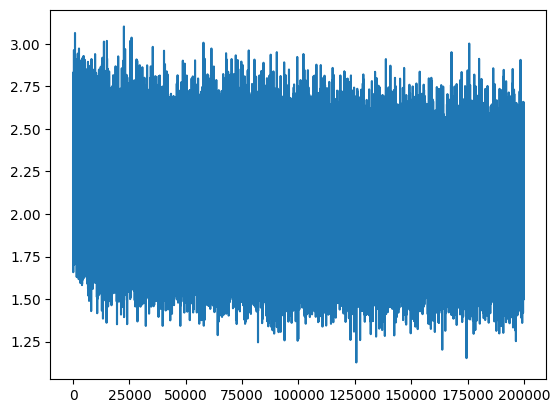

In [109]:
plt.plot(lossi)

In [103]:
for layer in layers:
    if type(layer).__name__ == "BatchNorm1d":
        layer.training = False

with torch.no_grad():
    context = [0] * block_size
    dummy = letter_embedding[torch.tensor([context])]
    output = dummy.view(1, -1)
    for layer in layers:
        output = layer(output)
    probs = F.softmax(output, dim=1)
    

In [111]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
      emb = letter_embedding[torch.tensor([context])]
      x = emb.view(1, -1) 
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

arelicilpia.
kayelle.
empryster.
coralynn.
taryy.
amar.
damieehaney.
meeki.
maishie.
rhydenah.
hailory.
mayuri.
shahabizma.
mauri.
emerayden.
leum.
kalaylor.
jochipa.
mani.
leonta.
